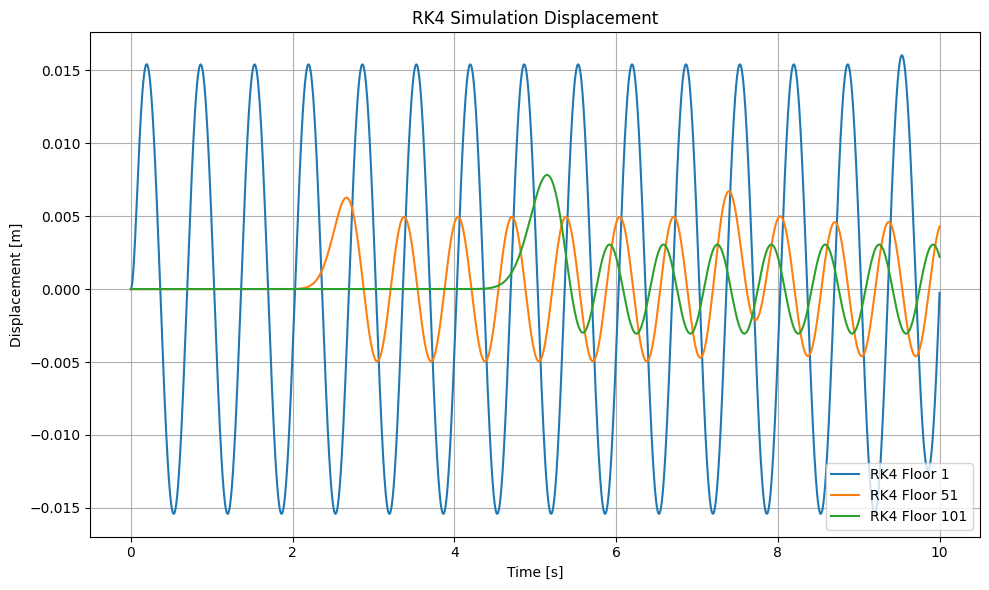

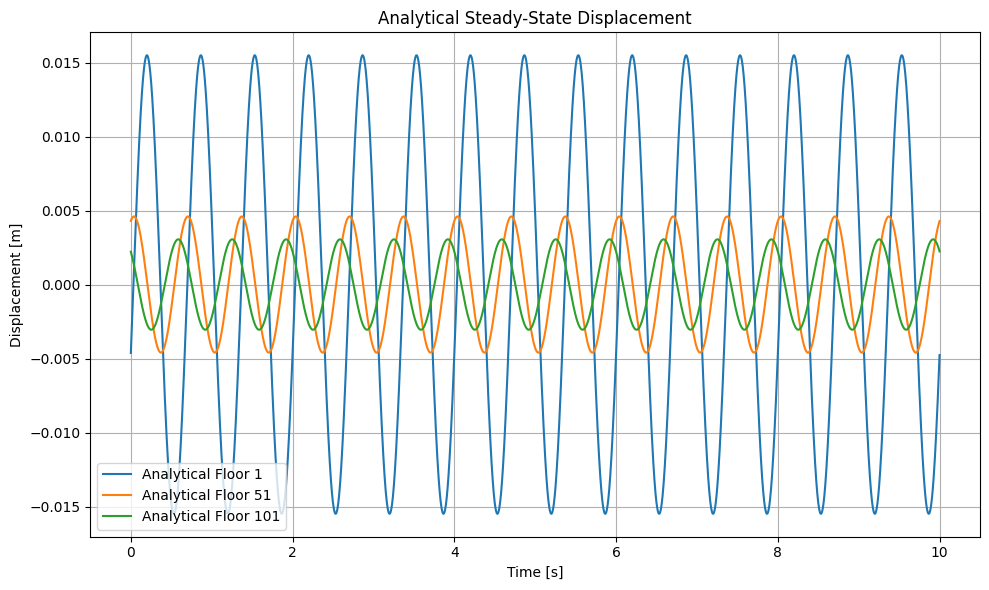

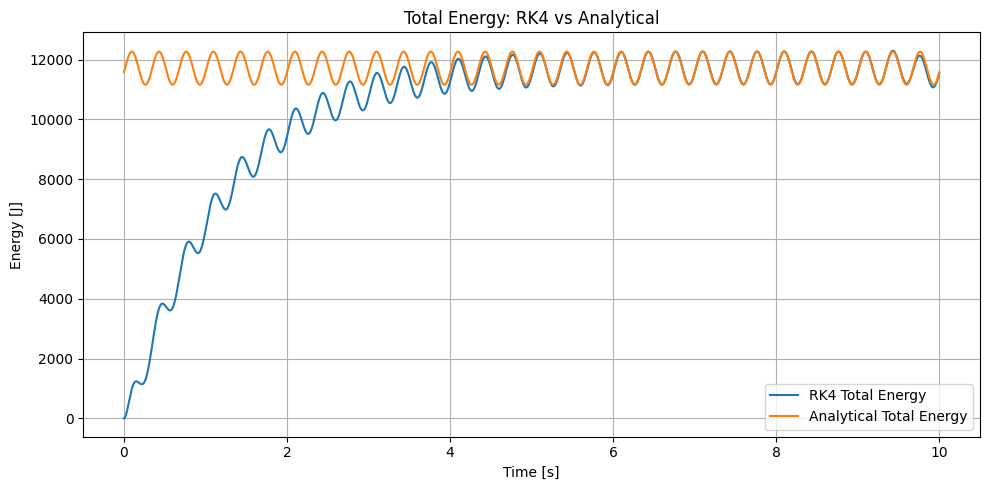

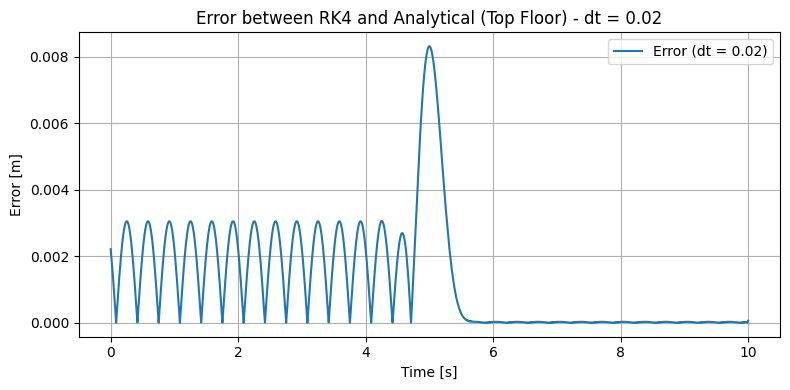

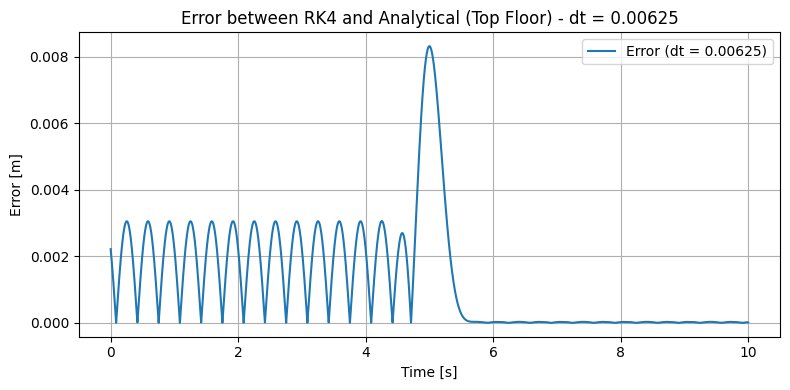

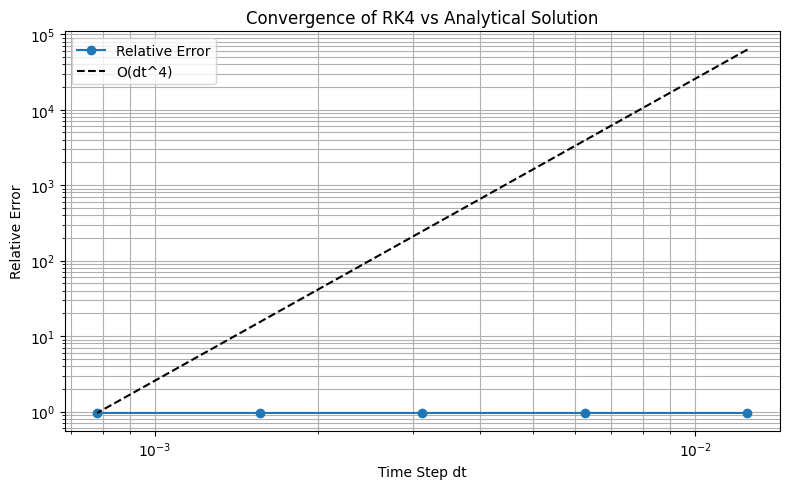

In [8]:
# AE 370 Project 1 - Tapeii 101 Building

# --- Project Setup ---
# System: Damped mass-spring model of Tapeii 101 with harmonic forcing
# Solution 1: Analytical steady-state response to F0 * cos(omega * t)
# Solution 2: RK4 time-domain simulation

# --- STEP 1: Import Packages ---
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

# --- STEP 2: Define System Parameters ---
n_floors = 101
m = 50000.0
k = 2e7
c = 2e5

M = m * np.eye(n_floors)
K = np.zeros((n_floors, n_floors))
C = np.zeros((n_floors, n_floors))
for i in range(n_floors):
    if i > 0:
        K[i, i] += k
        K[i, i - 1] -= k
        C[i, i] += c
        C[i, i - 1] -= c
    if i < n_floors - 1:
        K[i, i] += k
        K[i, i + 1] -= k
        C[i, i] += c
        C[i, i + 1] -= c

# --- STEP 3: Define Forcing ---
F0 = np.zeros(n_floors)
F0[0] = 0.3 * 9.81 * m
omega = 2 * np.pi * 1.5

def forcing(t):
    return F0 * np.cos(omega * t)

# --- STEP 4: Analytical Complex Amplitude Solution ---
j = 1j
Z = -omega**2 * M + j * omega * C + K
X_complex = solve(Z, F0)

T =10
dt = 0.001
t_vals = np.arange(0, T, dt)
X_analytical = np.real(np.outer(np.exp(j * omega * t_vals), X_complex))

# --- STEP 5: RK4 Implementation ---
def first_order_damped(t, Y):
    x = Y[:n_floors]
    v = Y[n_floors:]
    dxdt = v
    dvdt = solve(M, forcing(t) - C @ v - K @ x)
    return np.concatenate([dxdt, dvdt])

def rk4_step(f, t, y, dt):
    k1 = f(t, y)
    k2 = f(t + dt / 2, y + dt / 2 * k1)
    k3 = f(t + dt / 2, y + dt / 2 * k2)
    k4 = f(t + dt, y + dt * k3)
    return y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

# --- STEP 6: RK4 Simulation for Reference dt = 0.001 ---
Y0 = np.zeros(2 * n_floors)
Y_rk4 = np.zeros((len(t_vals), 2 * n_floors))
Y_rk4[0] = Y0
dt = 0.001
for i in range(1, len(t_vals)):
    Y_rk4[i] = rk4_step(first_order_damped, t_vals[i-1], Y_rk4[i-1], dt)

X_rk4 = Y_rk4[:, :n_floors]
V_rk4 = Y_rk4[:, n_floors:]

# --- STEP 7: Plot RK4 Displacement ---
plt.figure(figsize=(10, 6))
for i in range(0, n_floors, 50):
    plt.plot(t_vals, X_rk4[:, i], label=f'RK4 Floor {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('RK4 Simulation Displacement')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- STEP 8: Plot Analytical Solution ---
plt.figure(figsize=(10, 6))
for i in range(0, n_floors, 50):
    plt.plot(t_vals, X_analytical[:, i], label=f'Analytical Floor {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('Analytical Steady-State Displacement')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- STEP 9: Plot Energy Comparison ---
KE_rk4 = 0.5 * np.sum((V_rk4 @ M) * V_rk4, axis=1)
PE_rk4 = 0.5 * np.sum((X_rk4 @ K) * X_rk4, axis=1)
TE_rk4 = KE_rk4 + PE_rk4

V_true = np.gradient(X_analytical, dt, axis=0)
KE_true = 0.5 * np.sum((V_true @ M) * V_true, axis=1)
PE_true = 0.5 * np.sum((X_analytical @ K) * X_analytical, axis=1)
TE_true = KE_true + PE_true

plt.figure(figsize=(10, 5))
plt.plot(t_vals, TE_rk4, label='RK4 Total Energy')
plt.plot(t_vals, TE_true, label='Analytical Total Energy')
plt.xlabel('Time [s]')
plt.ylabel('Energy [J]')
plt.title('Total Energy: RK4 vs Analytical')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# --- STEP 10: Error for dt = 0.08 and 0.00625 ---
dt_list = [0.02, 0.00625]
error_results = {}

for dt_test in dt_list:
    t_test = np.arange(0, T, dt_test)
    Y_test = np.zeros((len(t_test), 2 * n_floors))
    Y_test[0] = Y0
    for i in range(1, len(t_test)):
        Y_test[i] = rk4_step(first_order_damped, t_test[i-1], Y_test[i-1], dt_test)
    X_test = Y_test[:, :n_floors]

    from scipy.interpolate import interp1d
    interp_func = interp1d(t_test, X_test[:, -1], kind='linear', fill_value='extrapolate')
    x_interp = interp_func(t_vals)
    error = np.abs(x_interp - X_analytical[:, -1])
    error_results[dt_test] = error

    plt.figure(figsize=(8, 4))
    plt.plot(t_vals, error, label=f'Error (dt = {dt_test})')
    plt.xlabel('Time [s]')
    plt.ylabel('Error [m]')
    plt.title(f'Error between RK4 and Analytical (Top Floor) - dt = {dt_test}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# --- STEP 11: Convergence Plot ---
dt_vals_conv = [0.0125, 0.00625,0.00625/2, 0.00625/4,0.00625/8]
errors = []

for dt_conv in dt_vals_conv:
    t_test = np.arange(0, T, dt_conv)
    Y_test = np.zeros((len(t_test), 2 * n_floors))
    Y_test[0] = Y0
    for i in range(1, len(t_test)):
        Y_test[i] = rk4_step(first_order_damped, t_test[i-1], Y_test[i-1], dt_conv)
    X_test = Y_test[:, :n_floors]
    interp_func = interp1d(t_test, X_test[:, -1], kind='linear', fill_value='extrapolate')
    x_interp = interp_func(t_vals)
    rel_error = np.linalg.norm(x_interp - X_analytical[:, -1]) / np.linalg.norm(X_analytical[:, -1])
    errors.append(rel_error)

plt.figure(figsize=(8, 5))
plt.loglog(dt_vals_conv, errors, 'o-', label='Relative Error')
plt.loglog(dt_vals_conv, [errors[-1]*(dt/dt_vals_conv[-1])**4 for dt in dt_vals_conv], 'k--', label='O(dt^4)')
plt.xlabel('Time Step dt')
plt.ylabel('Relative Error')
plt.title('Convergence of RK4 vs Analytical Solution')
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()